In [1]:
#Linear Regression Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
df = pd.read_csv("/kaggle/input/private-chicken-dataset/chicken_data.csv")
target = pd.read_csv("/kaggle/input/private-hen-productivity-target-labels/production_net.csv", sep=";")

In [4]:
df.rename(columns={
    "V1": "chicken1_id", "V2": "chicken2_id", "V3": "contact_duration",
    "V4": "antenna", "time": "timestamp", "time_": "mean_interaction"
}, inplace=True)
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])
df['chicken1_id'] = df['chicken1_id'].astype(str)
df['chicken2_id'] = df['chicken2_id'].astype(str)
df['both_ids'] = df['chicken1_id'] + "-" + df['chicken2_id']

In [5]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.dropna(subset=['date'], inplace=True)

In [6]:
df.dtypes
target.dtypes

Unnamed: 0                int64
date                     object
density                  object
nodes_n                   int64
crude_clus_coeff         object
                          ...  
flock_date               object
feed_per_bird             int64
water_per_bird            int64
Relative.humidity.9am    object
Relative.humidity.3pm    object
Length: 69, dtype: object

In [7]:
target.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,Unnamed: 0,date,density,nodes_n,crude_clus_coeff,assortativity_degree,path,path_distance,centr_degree_agg,centr_degree,...,Outdoor.Maximum.temperature..C.,Vapour.pressure.9am..kilopascal.,Vapour.pressure.3pm..kilopascal.,Windspeed..m.s.,Comments,flock_date,feed_per_bird,water_per_bird,Relative.humidity.9am,Relative.humidity.3pm
0,1,2017-02-27,"0,141544631712491",542,"0,571740028886168","0,19590224341695","2,07517171290012","0,00282864075524019","0,152355553130393","0,593270627715519",...,"28,44","1,49","1,62","4,22",NaN,27/02/2017,109,201,"74,1","39,2"
1,2,2017-03-01,"0,288063936989633",558,"0,525552386306049","0,0697787176634342","1,72002470994768","0,000701750927720139","0,250535703943939","0,991106992786497",...,"30,88","2,06","1,67","3,67",NaN,1/03/2017,122,215,"72,2","37,3"
2,3,2017-04-25,"0,478294837754647",584,"0,581421673749422","0,116500750354104","1,52185201719965","0,000550950472926633","0,266130548180173","1,69412462698842",...,"25,73","1,6","1,32","2,57",NaN,25/04/2017,116,180,"78,6","36,7"
3,4,2017-07-12,"0,691757642694306",532,"0,735592735017446","0,0479125214359517","1,30824235730569","0,000557696220229681","0,212197159565581","1,55312008835648",...,"18,19","0,87","0,87","3,21",NaN,12/07/2017,135,157,"72,8","38,3"
4,5,2017-07-22,"0,100201005025126",200,"0,759982253771074","0,399767987213646","2,04519857735625","0,00211120800997929","0,191256281407035","1,08331658291457",...,"19,27","0,7","0,7","1,69",NaN,22/07/2017,117,165,"80,5",30


In [8]:
egg_info = target[["date", "Total.eggs","Number.of.hens","Laying.rate...."]]
egg_info.head() # Laying Rate = (Total Eggs / Number of Hens) * 100

,date,Total.eggs,Number.of.hens,Laying.rate....
0,2017-02-27,36931,38891,"94,96027359"
1,2017-03-01,36654,38886,"94,26014504"
2,2017-04-25,35752,38586,"92,65536723"
3,2017-07-12,33954,37840,"89,73044397"
4,2017-07-22,33296,37720,"88,27147402"


In [9]:
eggs_per_day_df = egg_info[["date", "Laying.rate...."]].rename(columns={"Laying.rate....": "productivity_rate"})

In [10]:
eggs_per_day_df['date'] = pd.to_datetime(eggs_per_day_df['date'])

In [11]:
eggs_per_day_df['productivity_rate'] = eggs_per_day_df['productivity_rate'].str.replace(',', '.').astype(float)

In [12]:
eggs_per_day_df.dtypes

date                 datetime64[ns]
productivity_rate           float64
dtype: object

In [13]:
# Clean interaction data
df = df.drop_duplicates()
df = df.replace(["N/A", "NaN"], pd.NA)
df = df.dropna()

In [14]:
#Extract daily behavioral summaries.
daily_features = df.groupby("date").agg({
    "chicken1_id": pd.Series.nunique,
    "chicken2_id": pd.Series.nunique,
    "contact_duration": ["count", "mean", "std", "max"],
    "both_ids": pd.Series.nunique,
    "antenna": pd.Series.nunique
})
daily_features.columns = [
    "unique_chicken1", "unique_chicken2", "interaction_count", "avg_duration",
    "std_duration", "max_duration", "unique_pairs", "unique_locations"
]
daily_features = daily_features.reset_index()
daily_features["total_unique_hens"] = daily_features["unique_chicken1"] + daily_features["unique_chicken2"]
daily_features["interaction_density"] = daily_features["unique_pairs"] / daily_features["total_unique_hens"]

In [49]:
#Linear Regression Model 1 With Behavioral Data

In [50]:
#Read and Combine
laying_df = pd.read_csv("/kaggle/input/private-hen-productivity-target-labels/production_net.csv", sep=";")
laying_df['date'] = pd.to_datetime(laying_df['date'], errors='coerce')
laying_df['Laying.rate....'] = laying_df['Laying.rate....'].astype(str).str.replace(",", ".", regex=False).astype(float)
laying_df = laying_df[["date", "Laying.rate...."]].rename(columns={"Laying.rate....": "productivity_rate"})

merged = pd.merge(daily_features, laying_df, on="date", how="inner")

features1 = [
    "interaction_count", "avg_duration", "std_duration", "max_duration",
    "unique_pairs", "unique_locations", "total_unique_hens", "interaction_density"
]
X1 = merged[features1]
y1 = merged["productivity_rate"]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

In [51]:
#Train Model
model1 = LinearRegression()
model1.fit(X1_train, y1_train)
y1_pred = model1.predict(X1_test)
mse1 = mean_squared_error(y1_test, y1_pred)

rmse1 = np.sqrt(mean_squared_error(y1_test, y1_pred))
mae1 = mean_absolute_error(y1_test, y1_pred)
r2_1 = model1.score(X1_test, y1_test)

In [52]:
date_series = df.loc[X1_test.index, 'date']

In [53]:
print("RMSE:", rmse1)
print("MAE :", mae1)
print("Linear Regression MSE (only behavioral data):", mse1)

RMSE: 5.878947118708618
MAE : 4.000922113149561
Linear Regression MSE (only behavioral data): 34.56201922457237


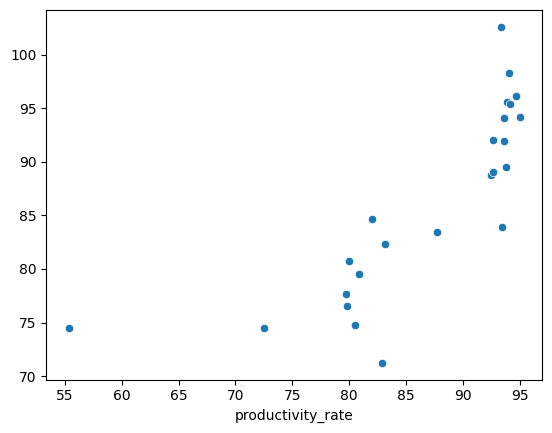

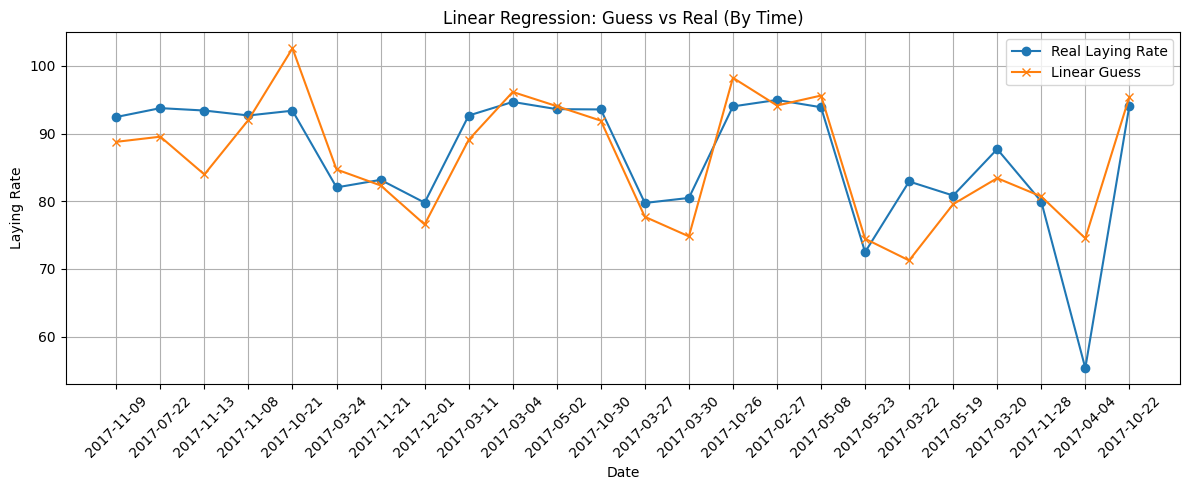

In [54]:
sns.scatterplot(x=y1_test, y=y1_pred)
plt.figure(figsize=(12, 5))
plt.plot(date_series, y1_test.values, label="Real Laying Rate", marker='o')
plt.plot(date_series, y1_pred, label="Linear Guess", marker='x')
plt.xticks(rotation=45)
plt.title("Linear Regression: Guess vs Real (By Time)")
plt.xlabel("Date")
plt.ylabel("Laying Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
#Linear Regression Model 2 With Environmental Data

In [22]:
df = pd.read_csv("/kaggle/input/private-hen-productivity-target-labels/production_net.csv", sep=";")
df.columns = df.columns.str.strip()
df["Laying.rate...."] = df["Laying.rate...."].astype(str).str.replace(",", ".", regex=False).astype(float)

drop_cols = ["Laying.rate....", "Total.eggs", "Number.of.hens"]
X2 = df[[col for col in df.columns if col not in drop_cols]]
y2 = df["Laying.rate...."]

In [23]:
# Process numerical and categorical data,
for col in X2.columns:
    if X2[col].dtype == "object":
        try:
            X2[col] = X2[col].astype(str).str.replace(",", ".", regex=False).astype(float)
        except:
            X2[col] = pd.factorize(X2[col])[0]

X2 = X2.fillna(0)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

/tmp/ipykernel_224/3643841084.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2[col] = pd.factorize(X2[col])[0]
/tmp/ipykernel_224/3643841084.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X2[col] = X2[col].astype(str).str.replace(",", ".", regex=False).astype(float)
/tmp/ipykernel_224/3643841084.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pan

In [24]:
model2 = LinearRegression()
model2.fit(X2_train, y2_train)
y2_pred = model2.predict(X2_test)
mse2 = mean_squared_error(y2_test, y2_pred)

rmse2 = np.sqrt(mean_squared_error(y2_test, y2_pred))
mae2 = mean_absolute_error(y2_test, y2_pred)
r2_2 = model2.score(X2_test, y2_test)

In [25]:
date_series = df.loc[X2_test.index, 'date']

In [26]:
print("RMSE:", rmse2)
print("MAE :", mae2)


print("Linear Regression MSE (Only behavioral data):", mse2)

RMSE: 0.46370758020154473
MAE : 0.24426828359152472
Linear Regression MSE (Only behavioral data): 0.21502471993637207


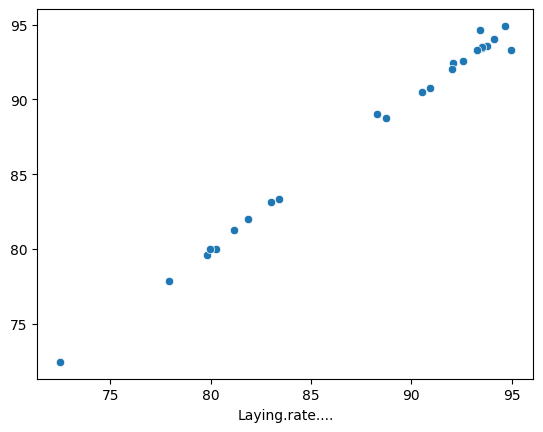

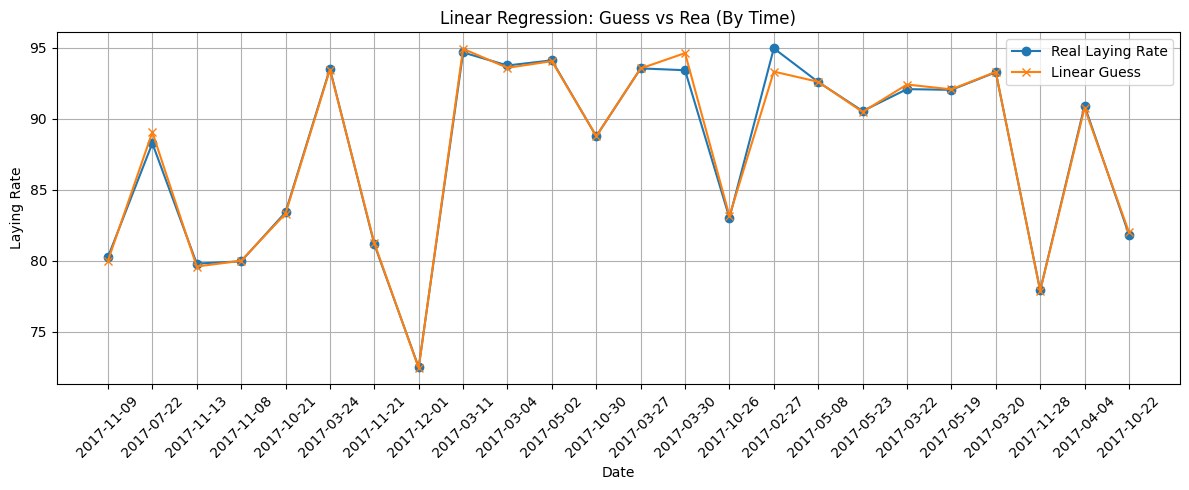

In [27]:
sns.scatterplot(x=y2_test, y=y2_pred)
plt.figure(figsize=(12, 5))
plt.plot(date_series, y2_test.values, label="Real Laying Rate", marker='o')
plt.plot(date_series, y2_pred, label="Linear Guess", marker='x')
plt.xticks(rotation=45)
plt.title("Linear Regression: Guess vs Rea (By Time)")
plt.xlabel("Date")
plt.ylabel("Laying Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
#Random Forest Model 

In [29]:
#Only Behavioral Data

In [30]:
from sklearn.ensemble import RandomForestRegressor

In [31]:
# Creating Model
rf_model_behavior = RandomForestRegressor(random_state=42)

In [32]:
# Training Model
rf_model_behavior.fit(X1_train, y1_train)

RandomForestRegressor(random_state=42)

In [33]:
# Guessing
y1_pred_rf = rf_model_behavior.predict(X1_test)

In [34]:
# Calculating MSE
rmse1_rf = np.sqrt(mean_squared_error(y1_test, y1_pred_rf))
mae1_rf = mean_absolute_error(y1_test, y1_pred_rf)
r2_1_rf = rf_model_behavior.score(X1_test, y1_test)

In [35]:
date_series = df.loc[X1_test.index, 'date']

In [36]:
print(f"RMSE: {rmse1_rf:.4f} | MAE: {mae1_rf:.4f} | R²: {r2_1_rf:.4f}")
print("-" * 50)

RMSE: 5.6475 | MAE: 3.4970 | R²: 0.6317
--------------------------------------------------


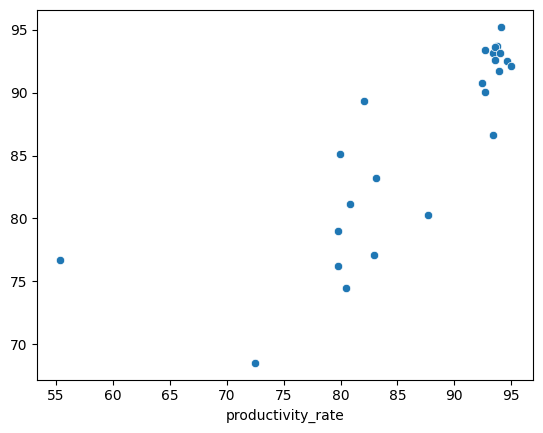

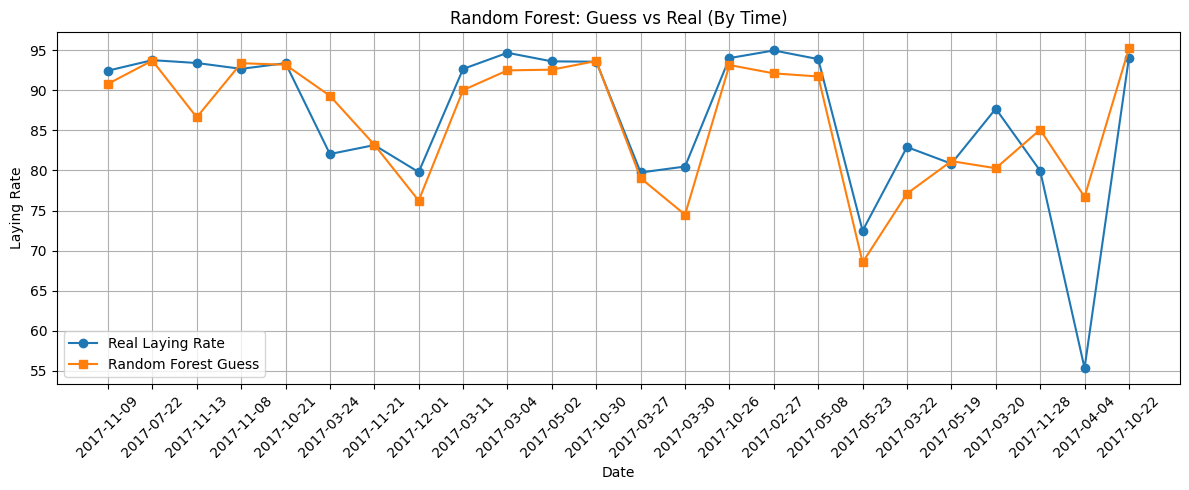

In [37]:
sns.scatterplot(x=y1_test, y=y1_pred_rf)
plt.figure(figsize=(12, 5))
plt.plot(date_series, y1_test.values, label="Real Laying Rate", marker='o')
plt.plot(date_series, y1_pred_rf, label="Random Forest Guess", marker='s')
plt.xticks(rotation=45)
plt.title("Random Forest: Guess vs Real (By Time)")
plt.xlabel("Date")
plt.ylabel("Laying Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [38]:
#Environmental Data

In [39]:
# Creating Model
rf_model_env = RandomForestRegressor(random_state=42)

In [40]:
# Training Model
rf_model_env.fit(X2_train, y2_train)

RandomForestRegressor(random_state=42)

In [41]:
# Guessing
y2_pred_rf = rf_model_env.predict(X2_test)

In [42]:
# Calculating MSE
rmse2_rf = np.sqrt(mean_squared_error(y2_test, y2_pred_rf))
mae2_rf = mean_absolute_error(y2_test, y2_pred_rf)
r2_2_rf = rf_model_env.score(X2_test, y2_test)

In [43]:
date_series = df.loc[X2_test.index, 'date']

In [44]:
print(f"RMSE: {rmse2_rf:.4f} | MAE: {mae2_rf:.4f} | R²: {r2_2_rf:.4f}")
print("-" * 50)

RMSE: 1.2119 | MAE: 0.7624 | R²: 0.9653
--------------------------------------------------


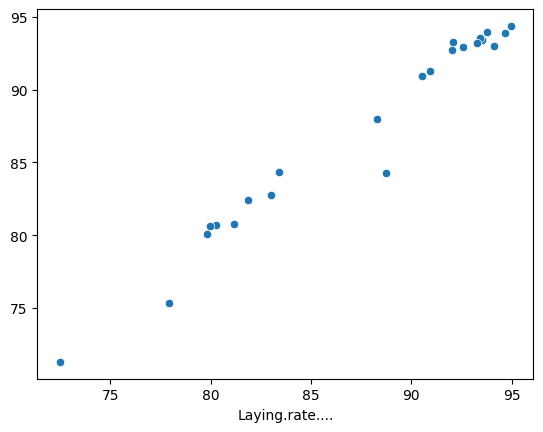

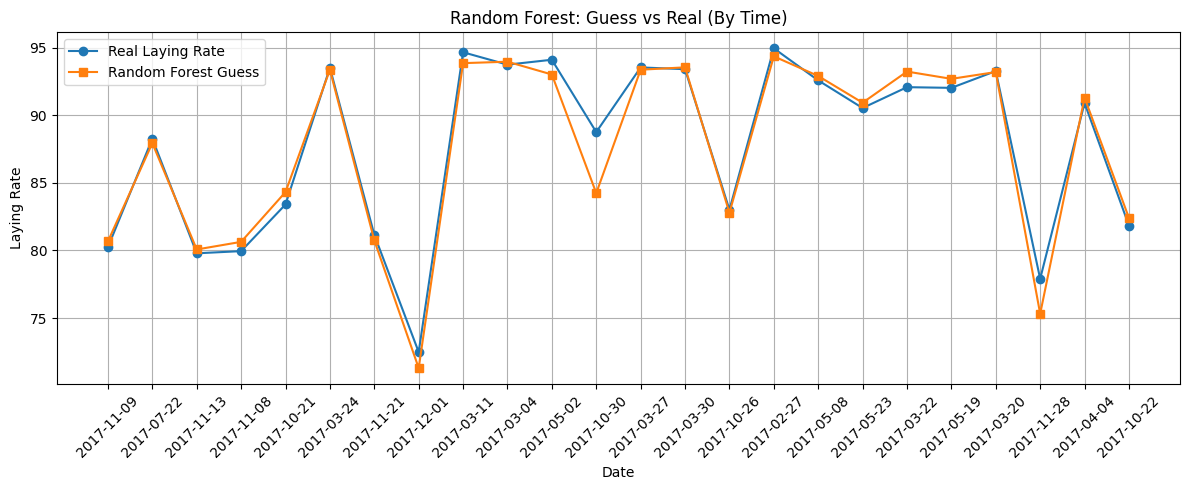

In [45]:
sns.scatterplot(x=y2_test, y=y2_pred_rf)
plt.figure(figsize=(12, 5))
plt.plot(date_series, y2_test.values, label="Real Laying Rate", marker='o')
plt.plot(date_series, y2_pred_rf, label="Random Forest Guess", marker='s')
plt.xticks(rotation=45)
plt.title("Random Forest: Guess vs Real (By Time)")
plt.xlabel("Date")
plt.ylabel("Laying Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()